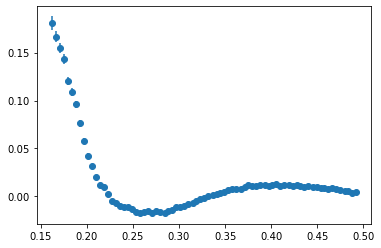

[[Variables]]
    mudc:     12.9821829 +/- 0.49395342 (3.80%) (init = 12)
    muds:     41.6919025 +/- 0.13336224 (0.32%) (init = 42)
    sigmadc:  0.12219059 +/- 0.05407825 (44.26%) (init = 0.1)
    rhom:     0.05847400 +/- 0.00400527 (6.85%) (init = 0.1)
    sigmads:  0.12 (fixed)
    rhos:     2.8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(mudc, rhom)    = -0.972
    C(mudc, sigmadc) = -0.970
    C(sigmadc, rhom) =  0.937
    C(muds, sigmadc) =  0.715
    C(mudc, muds)    = -0.623
    C(muds, rhom)    =  0.580


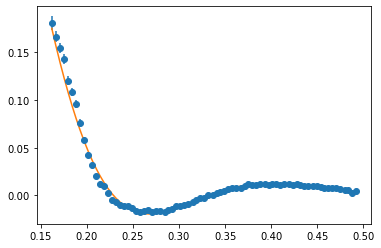

Figure A.1: plot of data and fit (least-squares fit)


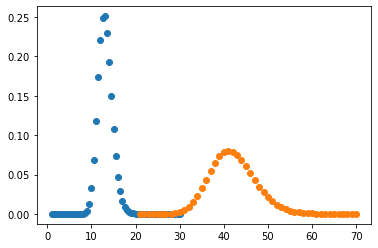

Figure A.2: lognormal distribution of core (blue) and total particle (orange) size (least-squares fit)


In [10]:
# In this notebook the size distributions are extracted from the nuclear-magnetic SANS cross term 
# of a sample of superparamagnetic core-shell iron oxide nanoparticles (surrounded by a silica shell)
# by assuming (i) lognormal distributions for the core and total particle size, that
# (ii) the iron oxide cores are homogeneously magnetized (i.e. magnetic := nuclear core size), 
# and by fitting the data with a combination of the form factor for spheres (magnetic part) 
# and the form factor for spherical core-shell particles (nuclear part).
# First, we perform a standard-least squares fit (Levenberg-Marquardt) and then use the fit results
# as starting values for a Bayesian refinement.
# The results are published in: 
# "The benefits of a Bayesian analysis for the characterization of magnetic nanoparticles"
# https://arxiv.org/abs/2005.09325

#==============================================================================
# Import of used packages

import numpy as np
import lmfit as lm
import matplotlib.pyplot as plt
import corner
import emcee
import time

#==============================================================================
# Import of data

q,Iq,sd=np.genfromtxt("../data/SANS-5T_data.txt",unpack=True,skip_header=0,skip_footer=0,usecols=(0,1,2))

qfit=np.logspace(-3,-1,100)

#==============================================================================
# Plot of data

plt.errorbar(q,Iq,sd, marker='o', ls='None', label='Observed')
plt.xscale('linear')
plt.yscale('linear')
plt.show()

#==============================================================================
# Definition of the fitting function

def lognor(d,sigma,mu): # lognormal distribution
    return 1./(np.sqrt(2.*np.pi)*sigma*d)*np.exp(-0.5*pow((np.log(d)-np.log(mu))/sigma,2))      

def V(d): # volume
    return 1./6.*np.pi*pow(d,3)

def FormNuc(q,ds,dc,rhos,rhoc): # (nuclear) form factor for core-shell spheres, index c = core, index s = shell
    return (3.*V(dc)*(rhoc-rhos)*pow(10,-6)*(np.sin(q*dc*0.5)-q*dc*0.5*np.cos(q*dc*0.5))/pow(q*dc*0.5,3)
            +3.*V(ds)*rhos*pow(10,-6)*(np.sin(q*ds*0.5)-q*ds*0.5*np.cos(q*ds*0.5))/pow(q*ds*0.5,3))

def FormMag(q,dc,rhom): # (magnetic) form factor for a sphere with dm = dc
    return 3.*V(dc)*rhom*pow(10,-6)*(np.sin(q*dc*0.5)-q*dc*0.5*np.cos(q*dc*0.5))/pow(q*dc*0.5,3)

rhoc = 6.9 # nuclear scattering length density (SLD) of the core
pre = pow(10,5) # prefactor; when q is in [1/nm] it's 10^5, when q is in [1/A] it's 10^8. 
                # but this is only relevant for corrected data with I in [1/cm]

dc = np.linspace(1,30,59) # bins of (nuclear = magnetic) core size distribution in [nm]
ds = np.linspace(21,70,50) # bins of total particle size distribution in [nm]  

def residuals(params): # fitting function; normalized to sigma
    mudc = params['mudc'].value
    muds = params['muds'].value
    sigmads = params['sigmads'].value
    sigmadc = params['sigmadc'].value
    rhos = params['rhos'].value
    rhom = params['rhom'].value

    model  = pre * np.trapz(np.trapz(lognor(dc[np.newaxis, np.newaxis, :],sigmadc,mudc) 
                                   * lognor(ds[np.newaxis, :,np.newaxis],sigmads,muds) 
                                   * FormNuc(q[:, np.newaxis,np.newaxis],ds[np.newaxis, :,np.newaxis],dc[np.newaxis, np.newaxis, :],rhos,rhoc)
                                   * FormMag(q[:, np.newaxis,np.newaxis],dc[np.newaxis, np.newaxis, :],rhom), x=dc), x=ds)
    return (model-Iq)/sd

params = lm.Parameters() # introduction of fitting pearameters. lmfit allows to set priors/boundaries
params.add('mudc', value=12., vary=True, min=0.) # median value of the core size (log-normal) distribution in [nm]
params.add('muds', value=42., vary=True, min=0.) # median value of the total particle size (log-normal) distribution in [nm]
params.add('sigmadc', value=0.1, vary=True, min=0.) # broadness of the total particle size (log-normal) distribution  
params.add('rhom', value=0.1, vary=True, min=0.) # field-dependent magnetic scattering length density of the core   
params.add('sigmads', value=0.12, vary=False, min=0.) # broadness of the core size (log-normal) distribution
params.add('rhos', value=2.8, vary=False, min=0.) # nuclear scattering length density of the shell         

#==============================================================================
#==============================================================================
# A) Standard least-squares fit
#==============================================================================
#==============================================================================
# A.1) Fit of data

res1 = lm.minimize(residuals, params, method='leastsq') # leastsq = Levenberg-Marquardt
lm.report_fit(res1.params)

Fit1 = Iq+res1.residual*sd # fit curve

#==============================================================================
# A.2) Plot of results

plt.errorbar(q,Iq,sd, marker='o', ls='None', label='Observed')
plt.plot(q,Fit1)
plt.xscale('linear')
plt.yscale('linear')
plt.show()
print('Figure A.1: plot of data and fit (least-squares fit)')

plt.plot(dc,lognor(dc,res1.params['sigmadc'].value,res1.params['mudc'].value),'o')
plt.plot(ds,lognor(ds,res1.params['sigmads'].value,res1.params['muds'].value),'o')
plt.show()
print('Figure A.2: lognormal distribution of core (blue) and total particle (orange) size (least-squares fit)')


100%|██████████████████████████████████████| 1000/1000 [20:24<00:00,  1.22s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 50.7323565   42.33757349  51.39808936  49.92316117]
[[Variables]]
    mudc:     13.0421550 +/- 0.31254606 (2.40%) (init = 12.98218)
    muds:     41.6831819 +/- 0.07745167 (0.19%) (init = 41.6919)
    sigmadc:  0.11489719 +/- 0.03921323 (34.13%) (init = 0.1221906)
    rhom:     0.05796198 +/- 0.00251215 (4.33%) (init = 0.058474)
    sigmads:  0.12 (fixed)
    rhos:     2.8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(mudc, rhom)    = -0.981
    C(mudc, sigmadc) = -0.961
    C(sigmadc, rhom) =  0.940
    C(muds, sigmadc) =  0.773
    C(mudc, muds)    = -0.729
    C(muds, rhom)    =  0.696


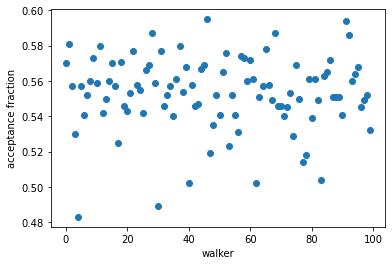

Figure B.1: Acceptance fraction for each walker (should be around 0.5)


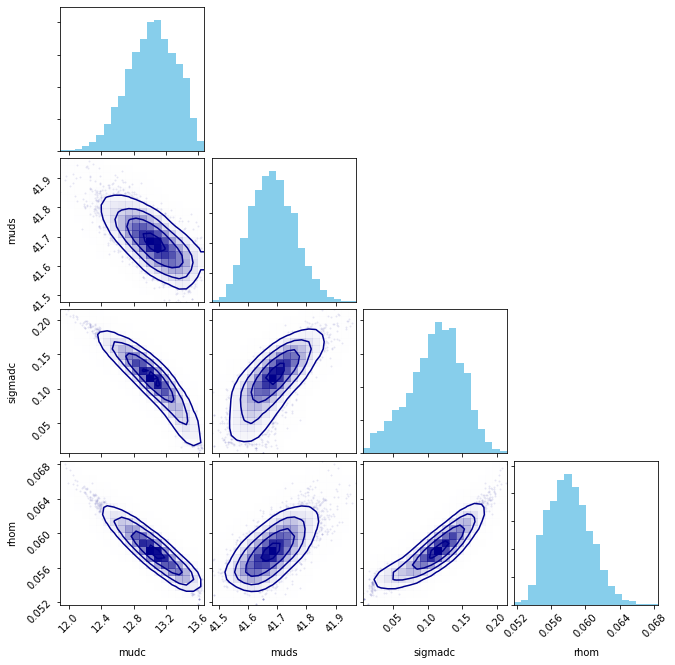

Figure B.2: corner plot of the parameter distributions and cross correlations (Bayes fit)


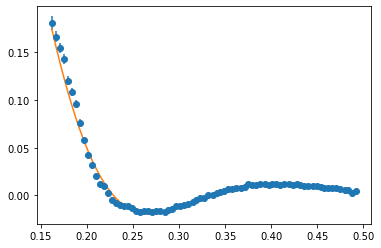

Figure B.3: plot of data and fit with linear scaling (Bayes fit)


In [11]:
#==============================================================================
#==============================================================================
# B) Bayes fit
#==============================================================================
#==============================================================================
# B.1) Fit of data

nwalkers=100 # should be set that it is much larger than number of parameters/variables. 100 is default
steps=1000 # number of samples you would like to draw from the posterior distribution for each of the walkers
burn=300 # Discard this many samples from the start of the sampling regime.
thin=20 # Only accept 1 in every thin samples.
params=res1.params # we use the fit results of the leastsq fit as starting values for the refinement

res2 = lm.minimize(residuals, method='emcee', nan_policy='omit', nwalkers=nwalkers, steps=steps, burn=burn, thin=thin, 
                   params=params, is_weighted=True, progress=True)
lm.report_fit(res2.params)

Fit2 = Iq+res2.residual*sd # fit curve

#==============================================================================
# B.2) Plot of results

plt.plot(res2.acceptance_fraction,'o')
plt.xlabel('walker')                               
plt.ylabel('acceptance fraction')
plt.show()
print('Figure B.1: Acceptance fraction for each walker (should be around 0.5)')

# corner plot
emcee_plot = corner.corner(res2.flatchain, labels=res2.var_names, color ='darkblue', truth_color='black',smooth=True,hist_kwargs=dict(histtype='stepfilled', color='skyblue'))
plt.show()
print('Figure B.2: corner plot of the parameter distributions and cross correlations (Bayes fit)')

plt.errorbar(q,Iq,sd, marker='o', ls='None', label='Observed')
plt.plot(q,Fit2)
plt.xscale('linear')
plt.yscale('linear')
plt.show()
print('Figure B.3: plot of data and fit with linear scaling (Bayes fit)')

In [12]:
highest_prob = np.argmax(res2.lnprob) # taken from https://lmfit.github.io/lmfit-py/fitting.html
hp_loc = np.unravel_index(highest_prob, res2.lnprob.shape)
mle_soln = res2.chain[hp_loc]

for i, par in enumerate(params):
    if i<len(mle_soln):
        params[par].value = mle_soln[i]

print('\nMaximum Likelihood Estimation from emcee       ')
print('-------------------------------------------------')
print('Parameter  MLE Value   Median Value   Uncertainty')
fmt = '  {:5s}  {:11.5f} {:11.5f}   {:11.5f}'.format
for name, param in params.items():
    if res2.params[name].stderr !=None:
        print(fmt(name, param.value, res2.params[name].value,
              res2.params[name].stderr))


Maximum Likelihood Estimation from emcee       
-------------------------------------------------
Parameter  MLE Value   Median Value   Uncertainty
  mudc      13.00682    13.04215       0.31255
  muds      41.68825    41.68318       0.07745
  sigmadc      0.11997     0.11490       0.03921
  rhom       0.05825     0.05796       0.00251
